In [71]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
#For geoplots
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes
import statsmodels
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import norm
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor as xgb
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

In [2]:
#Reading the dataset.
data = pd.read_csv('/home/shreyansh/Downloads/AB_NYC_2019.csv')

In [3]:
#Getting shape of data
data.shape

(48895, 16)

In [4]:
#Exploring the top 5 observations.
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


We can see that there are some NaN values in the last_review and reviews_per_month columns.


In [5]:
#describing the datasets.
data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


We can see that the price column has some irregularity as the minimum price of the apartment is 0 .

In [6]:
#null or missing values in the dataset.
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Missing values are present in the name, host_name, last_reviews and reviews_per_month columns.
In the above exploration part we can see that if the number_of_reviews is 0 then it does not make sense to have last_review and reviews_per_month and are marked as NaN.

In [7]:
#checking the assumption -> 0 reviews will have missing values in last_review and reviews_per_month columns.
assumption_test = data.loc[(data.last_review.isnull()) & (data.reviews_per_month.isnull()), ['number_of_reviews',  'last_reviews', 'reviews_per_month']]
assumption_test.head()

/home/shreyansh/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,number_of_reviews,last_reviews,reviews_per_month
2,0,NaN,NaN
19,0,NaN,NaN
26,0,NaN,NaN
36,0,NaN,NaN
38,0,NaN,NaN


so the assumption is true

In [8]:
assumption_test.shape

(10052, 3)

Since both the last_reviews and reviews_per_month both has number of the null values.For reviews_per_month we can replace the null values with 0 and sicne last_reviews is a datetime object so we will the null value as it is. 

In [9]:
data.reviews_per_month.fillna(0, inplace=True)

In [10]:
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

we will leave the null values in the name and host_name as it is not required for our explorartory data analysis

# Exploratory Data Analysis

Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
Name: neighbourhood, dtype: int64


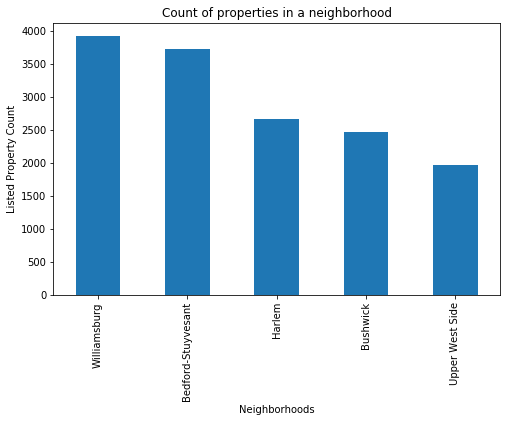

In [11]:
#checking the to 5 neighborhood where the properties are listed most.
top_5_neighborhoods = data.neighbourhood.value_counts().head(5)
print(top_5_neighborhoods)

#plotting 
plt.figure(figsize=(8,5))
top_5_neighborhoods.plot.bar()
plt.xlabel('Neighborhoods')
plt.ylabel('Listed Property Count')
plt.title('Count of properties in a neighborhood')
plt.show() #optional




The top 5 neighborhoods whcih have the highest number of properties listed are shown above.
We can see that Williamsburg has the highest number of properties listed (3920) followed by Bedford-Stuyvesant (3714).

As Williamsburg has the highest number of properties listed then the Brooklyn neighborhood group must also have the highest number of properties listed as williamburg comes under brooklyn neighborhood group.

Lets check if this is correct or not.

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64


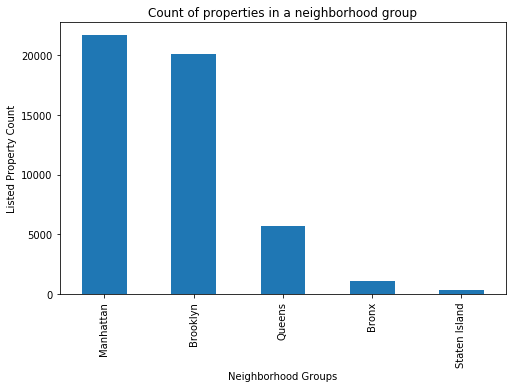

In [12]:
#checking the to 5 neighborhood groups where the properties are listed most.
top_5_neighborhood_group = data.neighbourhood_group.value_counts()
print(top_5_neighborhood_group)

#plotting 
plt.figure(figsize=(8,5))
top_5_neighborhood_group.plot.bar()
plt.xlabel('Neighborhood Groups')
plt.ylabel('Listed Property Count')
plt.title('Count of properties in a neighborhood group')
plt.show() #optional



Our assumption was wrong. As it turned out that Manhattan has the higghest number of properties listed although Williamsburg town in Brooklyn had the highest number of properties amongh the neighbor towns.

This infers that there are many other towns in Manhattan that have properties listed and that is why Manhattan neighborhood as a whole has the highest number of properties.

We can also see that other neighborhood groups such as Queens, Bronx and Staten Island contribute less compared to Manhattan and Brooklyn.


Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64


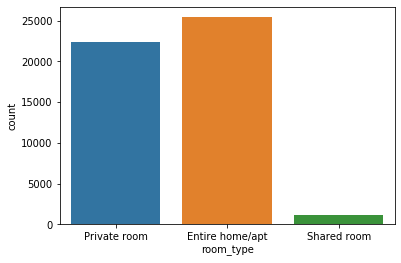

In [13]:
#number of rooms_type provided by the hosts
print(data.room_type.value_counts())
sns.countplot(data.room_type)



There are 3 room type provided by the host. Most of the rooms provided are private rooms and Entire home or apartments type.

Share rooms are listed very few, as it make sense that people travelling with family will prefer the top 2 room types rather than sharing.


Text(0.5, 1.0, 'Room Type vs Price')

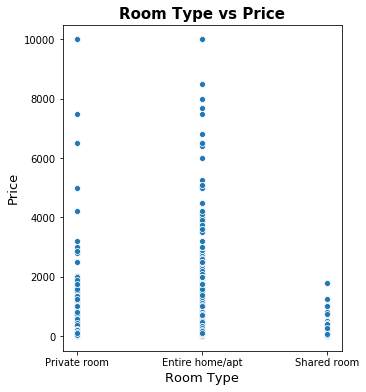

In [14]:
plt.figure(figsize=(5,6))
sns.scatterplot(x='room_type', y='price', data=data)

plt.xlabel("Room Type", size=13)
plt.ylabel("Price", size=13)
plt.title("Room Type vs Price",size=15, weight='bold')


This graph is about the relationship between price and room type. The Shared room price is always lower than 2000 dollars. On the other hand, the private room and the entire home have the highest price in some.

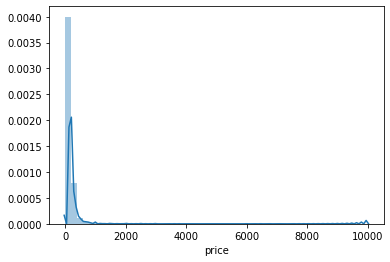

In [15]:
#Lets check the distribution of the price of the properties.
sns.distplot(data.price, bins=50)



The distribution of price is heavily left skewed. Meaning the most of the properties price are between 0 - 2000 and some minority of the properties are having prices grator than that making the data to be skewed.

Also we saw that some properties have a price as 0 and that could not be possible here as no one will be giving their property on rent for free! That will be absurd.


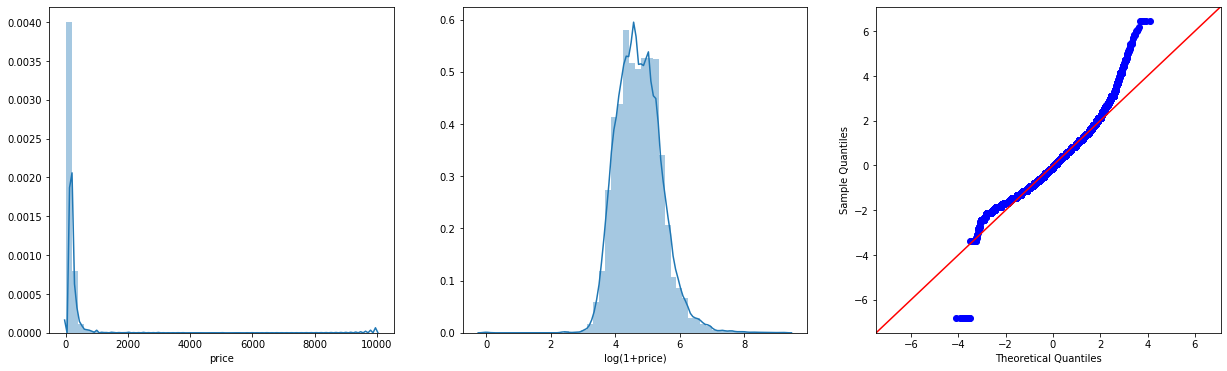

In [16]:
fig, axes = plt.subplots(1,3,figsize=(21,6))
sns.distplot(data['price'], ax=axes[0])
sns.distplot(np.log1p(data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(data['price']), stats.norm, fit=True, line='45', ax=axes[2]);


Price has a highly skewed distribution. This can cause problems for machine learning algorithms such as linear regression. A log transformation and removal of outliers makes the distribution look much closer to normal.

In [17]:
#converting to log
data['price'] = np.log(data.price+1)

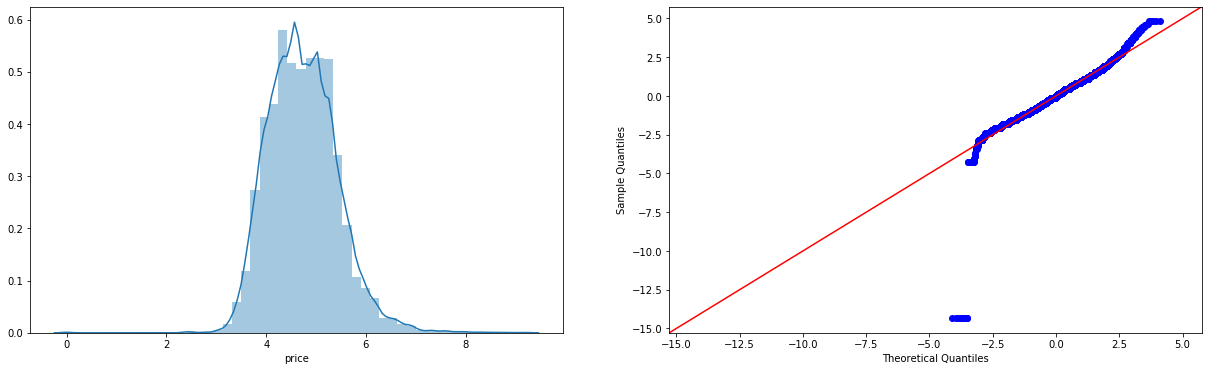

In [18]:
fig, axes = plt.subplots(1,2,figsize=(21,6))
sns.distplot(data['price'], ax=axes[0])
sm.qqplot(np.log1p(data['price']), stats.norm, fit=True, line='45', ax=axes[1]);

In [19]:
#Looking into the properties having 0 Price
free_properties = data.loc[data.price <= 0]
print('Shape of the data:', free_properties.shape)
free_properties.head()

Shape of the data: (11, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
23161,18750597,"Huge Brooklyn Brownstone Living, Close to it all.",8993084,Kimberly,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,0.0,4,1,2018-01-06,0.05,4,28
25433,20333471,★Hostel Style Room | Ideal Traveling Buddies★,131697576,Anisha,Bronx,East Morrisania,40.83296,-73.88668,Private room,0.0,2,55,2019-06-24,2.56,4,127
25634,20523843,"MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)",15787004,Martial Loft,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0.0,2,16,2019-05-18,0.71,5,0
25753,20608117,"Sunny, Quiet Room in Greenpoint",1641537,Lauren,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0.0,2,12,2017-10-27,0.53,2,0
25778,20624541,Modern apartment in the heart of Williamsburg,10132166,Aymeric,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0.0,5,3,2018-01-02,0.15,1,73




11 properties have are having 0 price. Assuming this to be a mistake or error from the Airbnb side, we will have to impute the prices according.

One way to impute will be by taking the mean, but as we saw earlier the price distribution is highly skewed and hence that will affect the mean of the price.

Presence of outliers or extreme values in the dataset effect the mean of the data and is not a good option to impute. Other method is to impute the data with mediian as median is less affected by outliers/extreme values.

The other effective way will be to see the affect of price or the relation of price on various other factors in the dataset and come up with a formula or a model that will do the imputation for us.
We will look into this later.


In [20]:
# since only 11 rows with price 0 exists, we can drop them
data.drop(data[(data['price']==0)].index,inplace=True,axis=0)

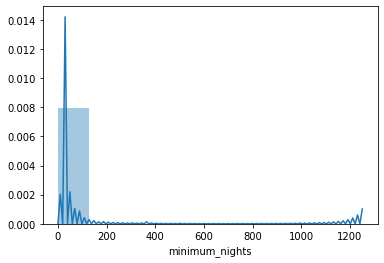

In [21]:
sns.distplot(data.minimum_nights, bins=10)




The minimum nights goes from 1 to 1200+. Only 1 host provide minimum_nights to be 1200+. We come to know from the distribution that the data is skewed.

Now let's check which top 5 properties have recieved the highest number of reviewes.


In [22]:
highest_reviews = data.sort_values(by='number_of_reviews', ascending=False)
highest_reviews.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
11759,9145202,Room near JFK Queen Bed,47621202,Dona,Queens,Jamaica,40.66730,-73.76831,Private room,3.871201,1,629,2019-07-05,14.58,2,333
2031,903972,Great Bedroom in Manhattan,4734398,Jj,Manhattan,Harlem,40.82085,-73.94025,Private room,3.912023,1,607,2019-06-21,7.75,3,293
2030,903947,Beautiful Bedroom in Manhattan,4734398,Jj,Manhattan,Harlem,40.82124,-73.93838,Private room,3.912023,1,597,2019-06-23,7.72,3,342
2015,891117,Private Bedroom in Manhattan,4734398,Jj,Manhattan,Harlem,40.82264,-73.94041,Private room,3.912023,1,594,2019-06-15,7.57,3,339
13495,10101135,Room Near JFK Twin Beds,47621202,Dona,Queens,Jamaica,40.66939,-73.76975,Private room,3.871201,1,576,2019-06-27,13.40,2,173


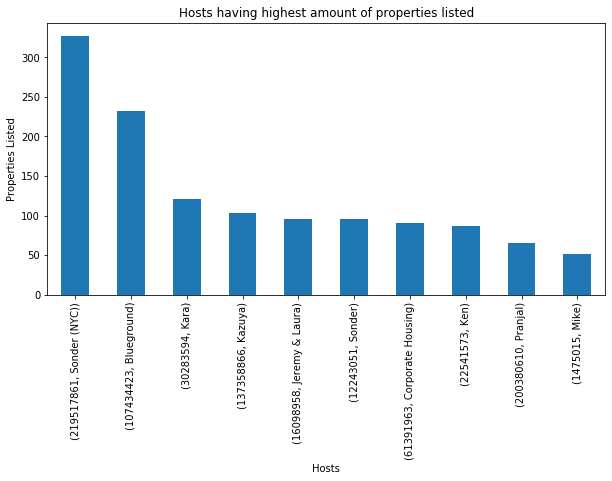

In [23]:
highest_props_host = data.groupby(['host_id', 'host_name'])['host_id'].count().sort_values(ascending=False)[:10]
highest_props_host.plot.bar(figsize=(10,5))
plt.xlabel('Hosts')
plt.ylabel('Properties Listed')
plt.title('Hosts having highest amount of properties listed');



We can see that Sonder(NYC) has the highest number of properties that are listed but his property was not in the top 5 highest reviews table we saw earlier.

This means that the number of properties listed on the Airbnb does not mean that the number of customers you will have will be more.


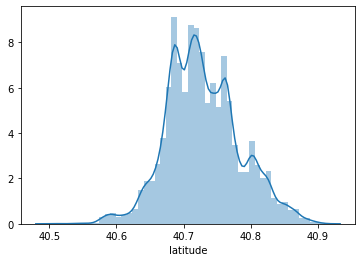

In [24]:
#dstribution of latitude
sns.distplot(data['latitude'])

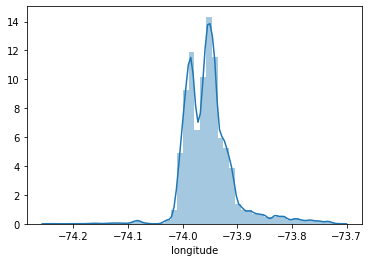

In [25]:
#distribution of longitude
sns.distplot(data['longitude'])

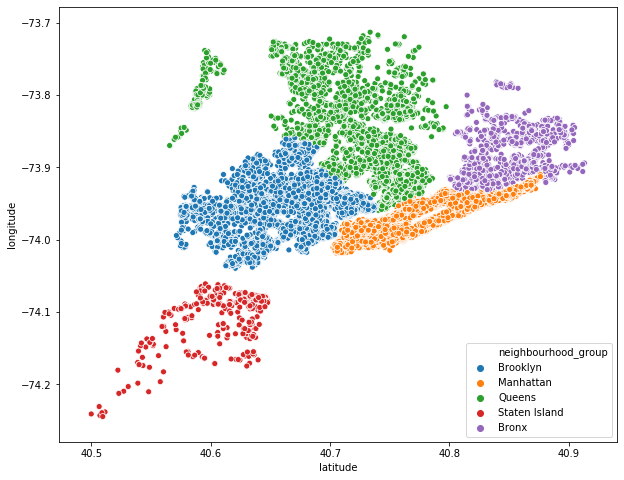

In [26]:
#neighborhood group based on the latitude and longitude
plt.figure(figsize=(10,8))
sns.scatterplot(data.latitude,data.longitude, hue='neighbourhood_group', data=data)

Text(0, 0.5, 'count')

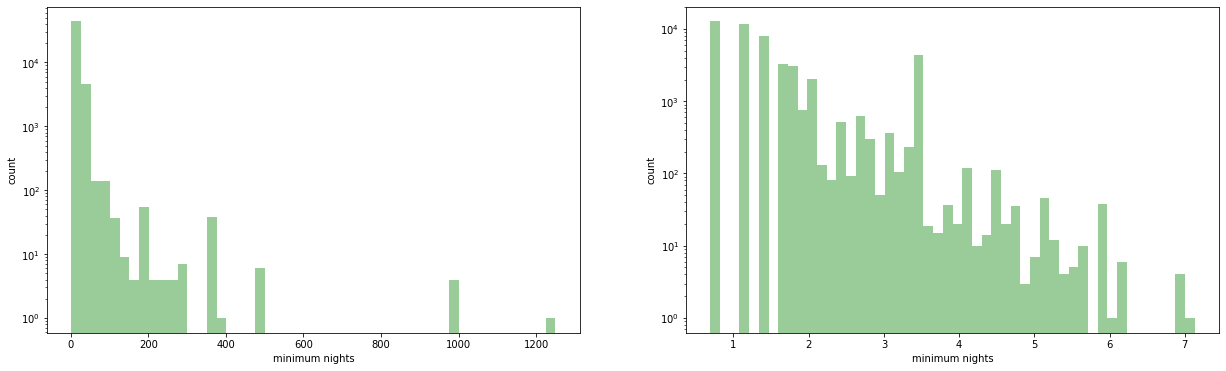

In [27]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))

sns.distplot(data['minimum_nights'], rug=False, kde=False, color="green", ax = axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('minimum nights')
axes[0].set_ylabel('count')

sns.distplot(np.log1p(data['minimum_nights']), rug=False, kde=False, color="green", ax = axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('minimum nights')
axes[1].set_ylabel('count')

since applying log removes skewness here, we will apply it on min nights

In [28]:
data['minimum_nights'] = np.log1p(data['minimum_nights'])

Text(0.5, 0, 'sqrt(reviews_per_month)')

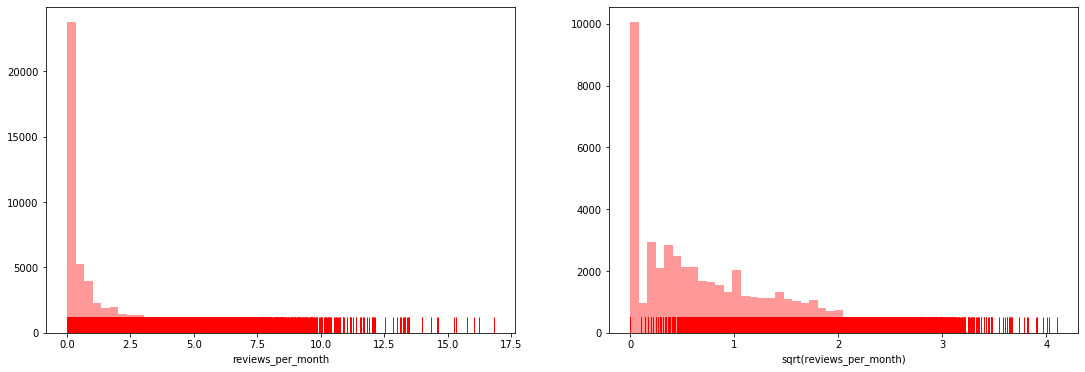

In [29]:
fig, axes = plt.subplots(1,2,figsize=(18.5, 6))
sns.distplot(data[data['reviews_per_month'] < 17.5]['reviews_per_month'], rug=True, kde=False, color="red", ax=axes[0])
sns.distplot(np.sqrt(data[data['reviews_per_month'] < 17.5]['reviews_per_month']), rug=True, kde=False, color="red", ax=axes[1])
axes[1].set_xlabel('sqrt(reviews_per_month)')

The distribution of the number of reviews per month is highly skewed. This is because there is a large weight on small numbers: there are a lot of properties which only get a few reviews and a rather large no of properties which get a lot of reviews.
One explanation would be that the properties which are available a larger fraction of the year get more reviews

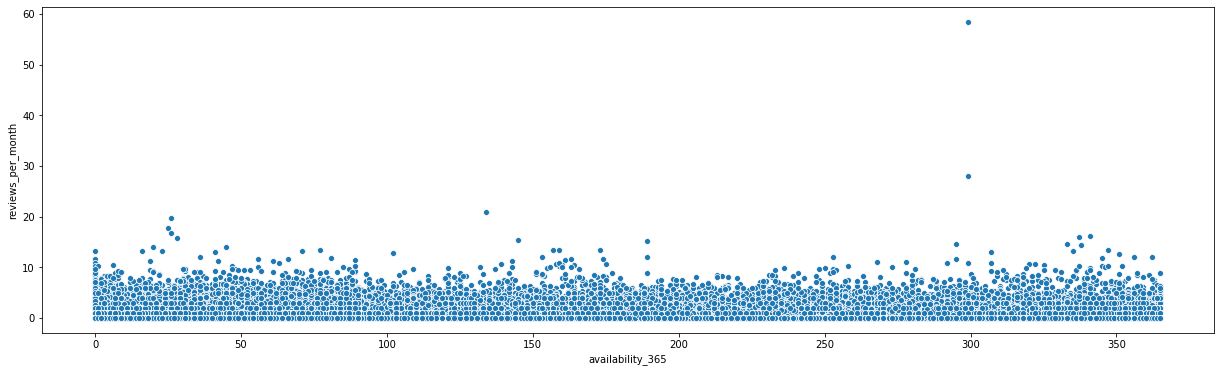

In [30]:
ig, axes = plt.subplots(1,1, figsize=(21,6))
sns.scatterplot(x= data['availability_365'], y=data['reviews_per_month'])

Above plot of reviews_per_month vs availabity_365 proves our hypothesis is wrong.

(0, 365)

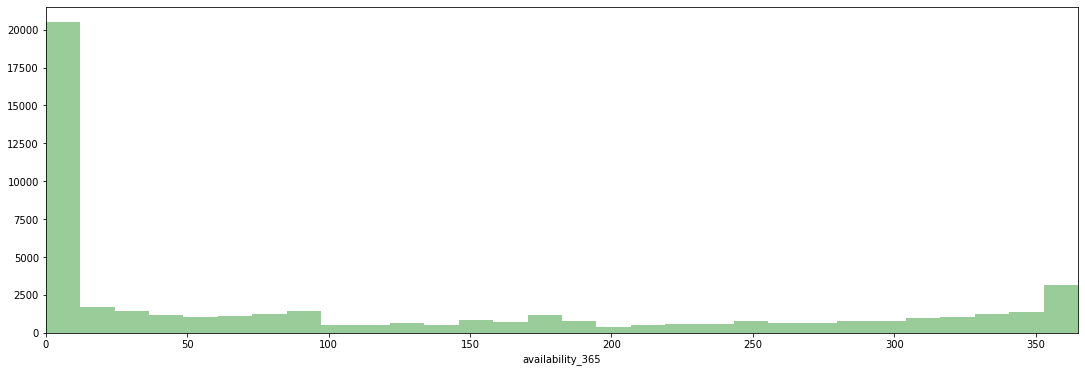

In [31]:
fig, axes = plt.subplots(1,1,figsize=(18.5, 6))
sns.distplot(data['availability_365'], rug=False, kde=False, color="green", ax=axes)
axes.set_xlabel('availability_365')
axes.set_xlim(0, 365)

There are large no of properties which are open only for a small time but a small no of properties open all year round.

# Feature Engineering

In [32]:
data.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [33]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,5.010635,0.693147,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,5.420535,0.693147,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,5.017280,1.386294,0,NaN,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,4.499810,0.693147,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,4.394449,2.397895,9,2018-11-19,0.10,1,0


We see that id, name, host_id, and host_name are present in a frequency equal to no of examples and 
these varibles anlaytically does not have a bearing on price of properties. So we will drop this columns.

In [34]:
data =data.drop(['id','name','host_id','host_name'], axis=1)

In [35]:
data.columns

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [36]:
data.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10051
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [37]:
#removing null in last_review
#datetime.toordinal() returns the day count from the date 01/01/01
data['last_review'] = pd.to_datetime(data['last_review'],infer_datetime_format=True) 

earliest = min(data['last_review'])
data['last_review'] = data['last_review'].fillna(earliest)
data['last_review'] = data['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal())

In [38]:
data.isnull().sum()
data.dtypes
data.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
count,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000
mean,40.728953,-73.952176,4.737951,1.499870,23.271991,2182.233001,1.090800,7.144628,112.779498
std,0.054532,0.046159,0.691782,0.869803,44.551331,1169.920057,1.597213,32.956185,131.627271
min,40.499790,-74.244420,2.397895,0.693147,0.000000,0.000000,0.000000,1.000000,0.000000
25%,40.690100,-73.983080,4.248495,0.693147,1.000000,1823.000000,0.040000,1.000000,0.000000
50%,40.723080,-73.955685,4.672829,1.386294,5.000000,2838.000000,0.370000,1.000000,45.000000
75%,40.763120,-73.936290,5.170484,1.791759,24.000000,3005.000000,1.580000,2.000000,227.000000
max,40.913060,-73.712990,9.210440,7.131699,629.000000,3024.000000,58.500000,327.000000,365.000000


In [39]:
data['all_year_avail'] = data['availability_365']>353
data['low_avail'] = data['availability_365']< 12
data['no_reviews'] = data['reviews_per_month']==0

In [40]:
data.columns
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,all_year_avail,low_avail,no_reviews
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,5.010635,0.693147,9,2762,0.21,6,365,True,False,False
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,5.420535,0.693147,45,2976,0.38,2,355,True,False,False
2,Manhattan,Harlem,40.80902,-73.94190,Private room,5.017280,1.386294,0,0,0.00,1,365,True,False,True
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,4.499810,0.693147,270,3021,4.64,1,194,False,False,False
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,4.394449,2.397895,9,2793,0.10,1,0,False,True,False


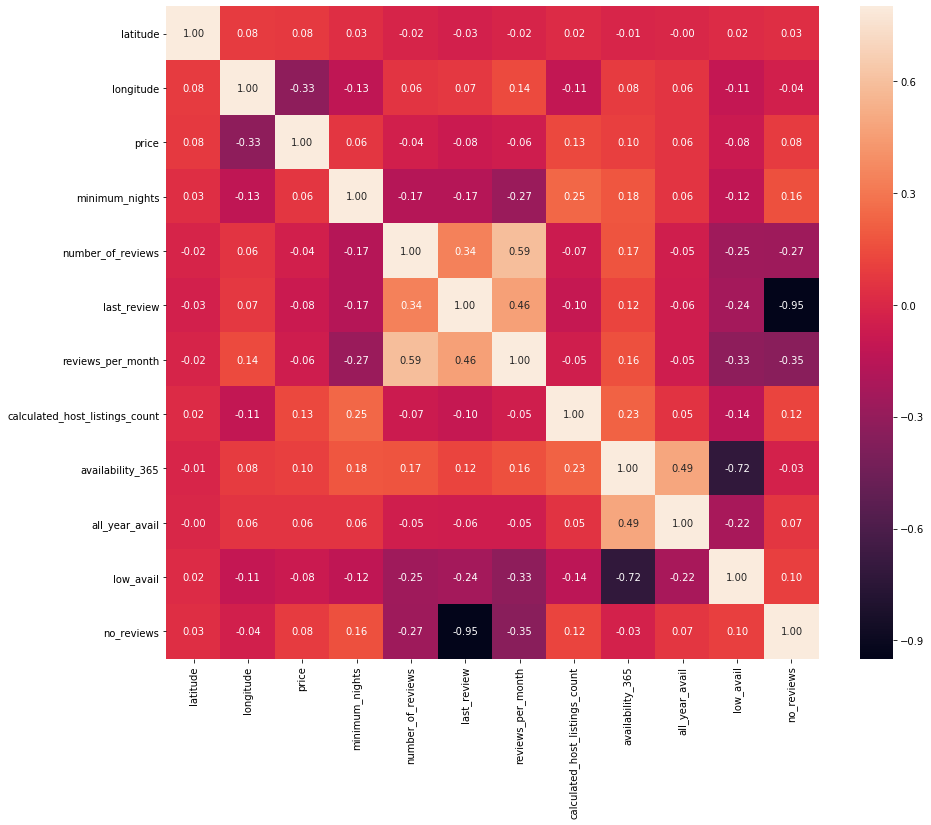

In [41]:
# Ploting Correlation heatmap 
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(data.corr(),annot=True, fmt=".2f", vmax=0.8, square=True)
sns.set(font_scale=0.8)

The above figure shows no_of_reviews has strong correlation with review_per_month which is trivial. 
All other relations doesnt show much prospect.

In [42]:
#Encoding Features
categorical_features = data.select_dtypes(include=['object'])
print('Categorical features: {}'.format(categorical_features.shape))

Categorical features: (48884, 3)


In [43]:
categorical_features_one_hot = pd.get_dummies(categorical_features)
categorical_features_one_hot.head()

,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [44]:
# Selecting numerical features
numerical_features =  data.select_dtypes(exclude=['object'])
y = numerical_features.price
numerical_features = numerical_features.drop(['price'], axis=1)
print('Numerical features: {}'.format(numerical_features.shape))

Numerical features: (48884, 11)


In [45]:
#Concatenating numerical and categorical(encoded)features 
X = np.concatenate((numerical_features, categorical_features_one_hot), axis=1)
X_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)
X_df.shape

(48884, 240)

In [46]:
Processed_data = pd.concat([X_df, y], axis = 1)
Processed_data.to_csv('NYC_Airbnb_Processed.dat')

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))


Dimensions of the training feature matrix: (39107, 240)
Dimensions of the training target vector: (39107,)
Dimensions of the test feature matrix: (9777, 240)
Dimensions of the test target vector: (9777,)


We now scale the design matrix with sklearn's RobustScaler() so that each column has zero mean and unit variance.
This helps the convergence of machine learning algorithms such as linear regression.



In [49]:
# Scaling the data
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Model

We will try three models LInear REgresssion, XGBoost and RandomForest. 

3 metrics will be calculated for evaluating predictions.
Mean Absolute Error (MAE) shows the difference between predictions and actual values.
Root Mean Square Error (RMSE) shows how accurately the model predicts the response.
R^2 will be calculated to find the goodness of fit measure.

In [64]:
#Applying  XGBoost
regressor = XGBRegressor(n_estimators=1000, learning_rate=0.1, early_stopping=5, max_depth=5, min_child_weight=1 )
regressor.fit(X_train,y_train)
pred=regressor.predict(X_test)

/home/shreyansh/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:18:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [65]:
print('MAE: %f'% mean_absolute_error(y_test, pred))
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test, pred)))   
print('R2: %f' % r2_score(y_test, pred))

MAE: 0.326189
RMSE: 0.459908
R2 0.559558


In [74]:
# Applying RandomForestRegressor
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train) 

/home/shreyansh/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [75]:
pred=rfr.predict(X_test)
print('MAE: %f'% mean_absolute_error(y_test, pred))
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test, pred)))   
print('R2: %f' % r2_score(y_test, pred))

MAE: 0.333623
RMSE: 0.468695
R2 0.542567


In [72]:
# Applying LinearRegression
lr = LinearRegression(copy_X= True, fit_intercept = True, normalize = True)
lr.fit(X_train, y_train)
lr_pred= lr.predict(X_test)

In [73]:
pred=lr.predict(X_test)
print('MAE: %f'% mean_absolute_error(y_test, pred))
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test, pred)))   
print('R2: %f' % r2_score(y_test, pred))

MAE: 7796415790.137283
RMSE: 385577003840.413269
R2 -309577545280291610820608.000000


By comparinig the metrices XGBoost proves to be the current best.

In [76]:
import pickle

In [78]:
filename = 'finalized_model.sav'
pickle.dump(regressor, open(filename, 'wb'))